<a href="https://colab.research.google.com/github/gracielu/w266_project_yelp/blob/master/Yelp_LSTM_MoreFeatures_with_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [324]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

In [325]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
# fix random seed for reproducibility
np.random.seed(7)

In [326]:
from google.colab import drive
drive.mount('/contents/')

Drive already mounted at /contents/; to attempt to forcibly remount, call drive.mount("/contents/", force_remount=True).


In [327]:
yelp_reviews=pd.read_csv("/contents/My Drive/W266/review_sample_1.csv")

In [328]:
yelp_reviews.head(2)

,business_id,state,city,categories,review_count,category,cuisine,review_id,user_id,stars,useful,funny,cool,text,date,length,labels,business_cnt,American,Asian,Mexican
0,hIgGkG1JnHX4xmVuOgegDw,AZ,Tempe,"Restaurants, Sandwiches, Cheesesteaks, Food, D...",516,Sandwiches,American,IlPefxI7zZo1OFz_Sevlew,w0pA_3W2rJVLj9ensvpUeg,5.0,0,0,0,My husband says this spot has the best origina...,2011-05-08 01:26:03,220,0,458,1,0,0
1,qQP2bCj8H8ddp9QG-zRZ-w,AZ,Phoenix,"Event Planning & Services, Caterers, Restauran...",153,Barbeque,American,B__K3bYpKoIjpHcTpzNM8A,wPmO2BCg73G2UjRSkjQjTA,2.0,0,0,0,"Food is just okay, not great. Meat is dry and ...",2019-03-28 22:07:40,165,0,131,1,0,0


In [329]:
yelp_reviews['cuisine'].value_counts()

American    26679
Asian        7100
Mexican      6221
Name: cuisine, dtype: int64

In [330]:
yelp_reviews['stars'].value_counts()

5.0    15110
4.0     9952
1.0     6112
3.0     4853
2.0     3973
Name: stars, dtype: int64

In [331]:
yelp_reviews.text[5]

"Good food and buzzing vibe at this place. Inside are tv's to watch sports. Outside patio is great seating on a nice day and eve. The food is so good we went there twice on a one week trip.  \nThe steak quesadilla is excellent.  It is more like ground steak in a nicely cooked non greasy quesadilla.  The brewery burger was outstanding and it comes with good fries.  Service is good and fast. Really enjoyed the place and even bought the t-shirt."

In [332]:
yelp_reviews.isnull().any()

business_id     False
state           False
city            False
categories      False
review_count    False
category        False
cuisine         False
review_id       False
user_id         False
stars           False
useful          False
funny           False
cool            False
text            False
date            False
length          False
labels          False
business_cnt    False
American        False
Asian           False
Mexican         False
dtype: bool

In [333]:
yelp_reviews.useful# reviews=reviews.groupby('cuisine').apply(lambda s: s.sample(50000))

0         0
1         0
2         1
3         0
4         0
         ..
39995     7
39996    48
39997     9
39998     7
39999     8
Name: useful, Length: 40000, dtype: int64

In [334]:
yelp_reviews['labels'].value_counts()

1    20000
0    20000
Name: labels, dtype: int64

In [335]:
yelp_sample = yelp_reviews.copy()
# yelp_sample = yelp_reviews[yelp_reviews['cuisine'] == 'Asian'].copy()

In [336]:
yelp_sample['star_deviation'] = yelp_sample['stars'] - yelp_sample.stars.mean()

### Data Preprocessing

In [337]:
texts = yelp_sample["text"].values
labels = yelp_sample["labels"].values
stars = yelp_sample["star_deviation"].values
#stars = yelp_sample["star_dummy"].values
#stars = yelp_sample["stars"].values
business_cnt = yelp_sample["business_cnt"].values
length = yelp_sample["length"].values
American = yelp_sample["American"].values
Asian = yelp_sample["Asian"].values
Mexican = yelp_sample["Mexican"].values

In [338]:
yelp_reviews["labels"].values[:5]

array([0, 0, 0, 0, 0])

In [339]:
print(texts.shape)
print(labels.shape)
print(stars.shape)
print(business_cnt.shape)
print(American.shape)
print(length.shape)

(40000,)
(40000,)
(40000,)
(40000,)
(40000,)
(40000,)


In [340]:
vocab_size=10000
max_len=500

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 52579 unique tokens.


In [341]:
print(sequences[:1])

[[15, 324, 732, 16, 257, 92, 1, 102, 966, 1563, 2209, 11, 729, 1, 517, 24, 4, 252, 520, 7, 332, 2, 1, 238, 9, 1171, 38, 517, 2, 20, 1822, 90, 1, 1400, 106, 964, 133, 30, 50]]


In [342]:
print(list(word_index.items())[0])
print(list(word_index.items())[100])

('the', 1)
('cheese', 101)


In [343]:
min(list(word_index.values()))

1

In [344]:
data = sequence.pad_sequences(sequences, 
                              maxlen=max_len,
                              padding='post', 
                              truncating='post'
                             )

In [345]:
data[0:5]

array([[  15,  324,  732, ...,    0,    0,    0],
       [  21,    9,   39, ...,    0,    0,    0],
       [   1, 2499,    9, ...,    0,    0,    0],
       [  16,   29,    9, ...,    0,    0,    0],
       [  86,   11,   28, ...,    0,    0,    0]], dtype=int32)

In [346]:
labels_b = to_categorical(np.asarray(labels))
print('Shape of data:', data.shape)
print('Shape of label:', labels.shape)
print('Shape of label:', labels_b.shape)

Shape of data: (40000, 500)
Shape of label: (40000,)
Shape of label: (40000, 2)


In [347]:
VALIDATION_SPLIT=0.2

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
labels_b = labels_b[indices]

stars = stars[indices]
business_cnt = business_cnt[indices]
length = length[indices]
American = American[indices]
Asian = Asian[indices]
Mexican = Mexican[indices]

nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
y_train_b = labels_b[:-nb_validation_samples]
x_test = data[-nb_validation_samples:]
y_test = labels[-nb_validation_samples:]
y_test_b = labels_b[-nb_validation_samples:]

stars_train = stars[:-nb_validation_samples]
stars_test = stars[-nb_validation_samples:]

business_cnt_train = business_cnt[:-nb_validation_samples]
business_cnt_test = business_cnt[-nb_validation_samples:]

length_train = length[:-nb_validation_samples]
length_test = length[-nb_validation_samples:]

American_train = American[:-nb_validation_samples]
American_test = American[-nb_validation_samples:]

Asian_train = Asian[:-nb_validation_samples]
Asian_test = Asian[-nb_validation_samples:]

Mexican_train = Mexican[:-nb_validation_samples]
Mexican_test = Mexican[-nb_validation_samples:]


In [348]:
print('Shape of x_train:', x_train.shape)
print('Shape of x_test:', x_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_train_b:', y_train_b.shape)
print('Shape of y_test:', y_test.shape)
print('Shape of y_test_b:', y_test_b.shape)

Shape of x_train: (32000, 500)
Shape of x_test: (8000, 500)
Shape of y_train: (32000,)
Shape of y_train_b: (32000, 2)
Shape of y_test: (8000,)
Shape of y_test_b: (8000, 2)


In [349]:
print(x_train[0:3])
print(y_train[0:3])

[[ 16   6   4 ...   0   0   0]
 [490 236  10 ...   0   0   0]
 [350   2  27 ...   0   0   0]]
[0 0 1]


In [350]:
dat2t = pd.DataFrame(stars_test, columns = ['stars'])
dat3t = pd.DataFrame(business_cnt_test, columns = ['business_cnt'])
dat4t = pd.DataFrame(length_test, columns = ['length'])
dat5t = pd.DataFrame(American_test, columns = ['American'])
dat6t = pd.DataFrame(Asian_test, columns = ['Asian'])
dat7t = pd.DataFrame(Mexican_test, columns = ['Mexican'])

#x2_test_tmp = pd.concat([dat2t, dat3t, dat4t, dat5t, dat6t, dat7t], axis=1)

x2_test_tmp = pd.concat([dat2t, dat3t, dat4t], axis=1)

x2_test=(x2_test_tmp-x2_test_tmp.mean())/x2_test_tmp.std()

x2_test = np.array(x2_test).reshape(int(VALIDATION_SPLIT * data.shape[0]), x2_test_tmp.shape[1])

In [351]:
dat2 = pd.DataFrame(stars_train, columns = ['stars'])
dat3 = pd.DataFrame(business_cnt_train, columns = ['business_cnt'])
dat4 = pd.DataFrame(length_train, columns = ['length'])
dat5 = pd.DataFrame(American_train, columns = ['American'])
dat6 = pd.DataFrame(Asian_train, columns = ['Asian'])
dat7 = pd.DataFrame(Mexican_train, columns = ['Mexican'])

#x2_train_tmp = pd.concat([dat2, dat3, dat4, dat5, dat6, dat7], axis=1)
x2_train_tmp = pd.concat([dat2, dat3, dat4], axis=1)

print(x2_train_tmp.shape)
x2_train_tmp.head()

(32000, 3)


,stars,business_cnt,length
0,-2.599375,274,1051
1,1.400625,301,459
2,-1.599375,379,1481
3,1.400625,309,189
4,1.400625,313,191


In [352]:
x2_train=(x2_train_tmp-x2_train_tmp.mean())/x2_train_tmp.std()
x2_train = np.array(x2_train).reshape(int((1-VALIDATION_SPLIT) * data.shape[0]), x2_train_tmp.shape[1])

In [353]:
# Explore other features

from sklearn.linear_model import LogisticRegression
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn import metrics
clf = LogisticRegression()
clf.fit(x2_train, y_train)
predicted= clf.predict(x2_test)

print("Logistic Regression accuracy:", metrics.accuracy_score(y_test, predicted))

print(clf.coef_)

Logistic Regression accuracy: 0.74075
[[-0.09947372 -0.07013056  1.69971254]]


### Simple LSTM Classifier

In [354]:
#Simple LSTM Classifier
embedding_units = 200
rnn_units = 256
#attn_units=128

#Simple LSTM Classifier
sequence_input = layers.Input(shape=(max_len,),name="input_layer", dtype='int32')
embeddings = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_units, input_length=max_len,name="embedding_layer")(sequence_input)
rnn_output=tf.keras.layers.LSTM(rnn_units,name='LSTM')(embeddings)
output = keras.layers.Dense(1, activation='sigmoid',name='output_layer')(rnn_output)
simple_model = keras.Model(inputs=sequence_input, outputs=output)

simple_model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 500)]             0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 500, 200)          2000000   
_________________________________________________________________
LSTM (LSTM)                  (None, 256)               467968    
_________________________________________________________________
output_layer (Dense)         (None, 1)                 257       
Total params: 2,468,225
Trainable params: 2,468,225
Non-trainable params: 0
_________________________________________________________________


In [355]:
simple_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        min_delta=0,
                                                        patience=3,
                                                        verbose=0, mode='auto')

In [356]:
history = simple_model.fit(x_train,
                    y_train,
                    epochs=5,
                    batch_size=200,
                    validation_split=.3, verbose=1, callbacks=[early_stopping_callback])

Epoch 1/5
112/112 [==============================] - 22s 194ms/step - loss: 0.6950 - accuracy: 0.5150 - val_loss: 0.6851 - val_accuracy: 0.5273
Epoch 2/5
112/112 [==============================] - 21s 189ms/step - loss: 0.6893 - accuracy: 0.5181 - val_loss: 0.6797 - val_accuracy: 0.5273
Epoch 3/5
112/112 [==============================] - 21s 187ms/step - loss: 0.6832 - accuracy: 0.5172 - val_loss: 0.6813 - val_accuracy: 0.5271
Epoch 4/5
112/112 [==============================] - 21s 188ms/step - loss: 0.6798 - accuracy: 0.5195 - val_loss: 0.6793 - val_accuracy: 0.5302
Epoch 5/5
112/112 [==============================] - 21s 188ms/step - loss: 0.6791 - accuracy: 0.5210 - val_loss: 0.6799 - val_accuracy: 0.5272


In [357]:
# Final evaluation of the model
scores = simple_model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 53.05%


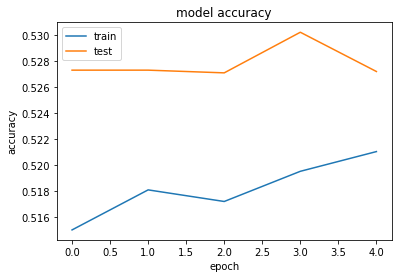

In [358]:
# summarize history for accuracy


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Bidirectional LSTM Classifier

In [359]:
from tensorflow.keras.layers import Bidirectional

sequence_input = layers.Input(shape=(max_len,),name="input_layer", dtype='int32')
embeddings = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_units, input_length=max_len,name="embedding_layer")(sequence_input)
rnn_output=Bidirectional(tf.keras.layers.LSTM(rnn_units,name='LSTM'))(embeddings)
output = keras.layers.Dense(1, activation='sigmoid',name='output_layer')(rnn_output)
bidirectional_model = keras.Model(inputs=sequence_input, outputs=output)

bidirectional_model.summary()

bidirectional_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        min_delta=0,
                                                        patience=3,
                                                        verbose=0, mode='auto')

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 500)]             0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 500, 200)          2000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 512)               935936    
_________________________________________________________________
output_layer (Dense)         (None, 1)                 513       
Total params: 2,936,449
Trainable params: 2,936,449
Non-trainable params: 0
_________________________________________________________________


In [360]:
history = bidirectional_model.fit(x_train, y_train, validation_split=.3,
          epochs=2, batch_size=200);

Epoch 1/2
112/112 [==============================] - 38s 338ms/step - loss: 0.5745 - accuracy: 0.7034 - val_loss: 0.5084 - val_accuracy: 0.7644
Epoch 2/2
112/112 [==============================] - 37s 332ms/step - loss: 0.4961 - accuracy: 0.7756 - val_loss: 0.5105 - val_accuracy: 0.7638


In [361]:
scores = bidirectional_model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 75.41%


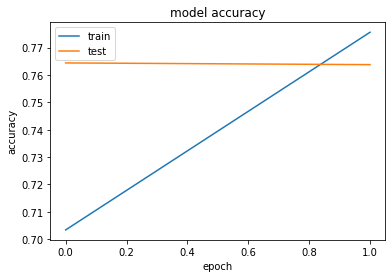

In [362]:
# summarize history for accuracy


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### LSTM Classifier with attention

In [363]:
#our attention layer, uses Bahdanau Attention from 2015 paper that's essentially weighted sum, also known as "additive attention"
class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self._name="Attention"
 
    def call(self, features, hidden):
    # hidden state shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        
    # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
    # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [364]:
#LSTM Classifier with Attention
attn_units=128

sequence_input = layers.Input(shape=(max_len,),name="input_layer", dtype='int32')
embeddings = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_units, input_length=max_len,name="embedding_layer")(sequence_input)
lstm_output,hidden_h, hidden_c=tf.keras.layers.LSTM(rnn_units,name='LSTM',return_sequences=True,
                                      return_state=True)(embeddings)
context_vector, attention_weights = BahdanauAttention(attn_units)(lstm_output, hidden_h)
output = keras.layers.Dense(1, activation='sigmoid',name='output_layer')(context_vector)
attn_model = keras.Model(inputs=sequence_input, outputs=output)
 
# summarize layers
attn_model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 500)]             0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 500, 200)          2000000   
_________________________________________________________________
LSTM (LSTM)                  [(None, 500, 256), (None, 467968    
_________________________________________________________________
Attention (BahdanauAttention ((None, 256), (None, 500, 65921     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 257       
Total params: 2,534,146
Trainable params: 2,534,146
Non-trainable params: 0
_________________________________________________________________


In [365]:
attn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        min_delta=0,
                                                        patience=3,
                                                        verbose=0, mode='auto')

In [366]:
history = attn_model.fit(x_train,
                    y_train,
                    epochs=2,
                    batch_size=200,
                    validation_split=.3, verbose=1, callbacks=[early_stopping_callback])

Epoch 1/2
112/112 [==============================] - 23s 208ms/step - loss: 0.5470 - accuracy: 0.7270 - val_loss: 0.5046 - val_accuracy: 0.7644
Epoch 2/2
112/112 [==============================] - 23s 205ms/step - loss: 0.4852 - accuracy: 0.7751 - val_loss: 0.5000 - val_accuracy: 0.7684


In [367]:
result = attn_model.evaluate(x_test, y_test)
print(result)

250/250 [==============================] - 4s 15ms/step - loss: 0.5053 - accuracy: 0.7600
[0.5052657723426819, 0.7599999904632568]


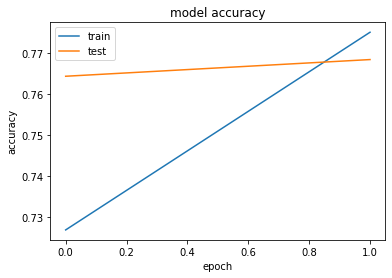

In [368]:
# summarize history for accuracy


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### LSTM Classifier with attention and GloVe embedding

In [369]:
import os
import itertools
embeddings_index = {}
f = open(os.path.join('/contents/My Drive/W266', 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [370]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 52579 unique tokens.


In [371]:
vocab_size = len(word_index) + 1

embedding_dim = 50


# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

In [372]:
attn_units=128
sequence_input = layers.Input(shape=(max_len,),name="input_layer", dtype='int32')
#put in glove embeddings in weights
embeddings = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, weights=[embedding_matrix], name="embedding_layer", trainable = 'false')(sequence_input)
lstm_output,hidden_h, hidden_c=tf.keras.layers.LSTM(rnn_units,name='LSTM',return_sequences=True,
                                      return_state=True)(embeddings)
context_vector, attention_weights = BahdanauAttention(attn_units)(lstm_output, hidden_h)
output = keras.layers.Dense(1, activation='sigmoid',name='output_layer')(context_vector)
glove_attn_model = keras.Model(inputs=sequence_input, outputs=output)
 
# summarize layers
glove_attn_model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 500)]             0         
_________________________________________________________________
embedding_layer (Embedding)  (None, 500, 50)           2629000   
_________________________________________________________________
LSTM (LSTM)                  [(None, 500, 256), (None, 314368    
_________________________________________________________________
Attention (BahdanauAttention ((None, 256), (None, 500, 65921     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 257       
Total params: 3,009,546
Trainable params: 3,009,546
Non-trainable params: 0
_________________________________________________________________


In [373]:
glove_attn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        min_delta=0,
                                                        patience=3,
                                                        verbose=0, mode='auto')

In [374]:
history = glove_attn_model.fit(x_train,
                    y_train,
                    epochs=2,
                    batch_size=200,
                    validation_split=.3, verbose=1, callbacks=[early_stopping_callback])

Epoch 1/2
112/112 [==============================] - 18s 160ms/step - loss: 0.5530 - accuracy: 0.7196 - val_loss: 0.5383 - val_accuracy: 0.7334
Epoch 2/2
112/112 [==============================] - 18s 159ms/step - loss: 0.5293 - accuracy: 0.7390 - val_loss: 0.5143 - val_accuracy: 0.7570


In [375]:
result = glove_attn_model.evaluate(x_test, y_test)
print(result)

250/250 [==============================] - 3s 13ms/step - loss: 0.5176 - accuracy: 0.7524
[0.5176299810409546, 0.7523750066757202]


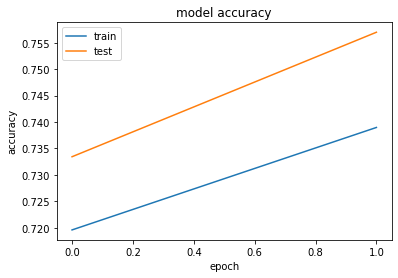

In [376]:
# summarize history for accuracy


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Additional Features

In [377]:
attn_units = 128
#embedding_units = 200
rnn_units = 256

#LSTM Classifier with Attention
sequence_input = layers.Input(shape=(max_len,),name="input_layer", dtype='int32')
embeddings = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, weights=[embedding_matrix], name="embedding_layer", trainable = 'false')(sequence_input)
lstm_output,hidden_h, hidden_c=(tf.keras.layers.LSTM(rnn_units,name='LSTM',return_sequences=True,
                                      return_state=True))(embeddings)
context_vector, attention_weights = BahdanauAttention(attn_units)(lstm_output, hidden_h)

other_input = layers.Input(shape=(x2_train.shape[1],),name="input_other", dtype='float32')

concat_output = tf.keras.layers.Concatenate()([context_vector, other_input])

Dense1 = keras.layers.Dense(100, activation='relu',name='dense1')(concat_output)
Dense2 = keras.layers.Dense(30, activation='relu',name='dense2')(Dense1)
output = keras.layers.Dense(1, activation='sigmoid',name='output_layer')(Dense2)

attn_model_f = keras.Model(inputs=[sequence_input, other_input], outputs=output)
 
# summarize layers
attn_model_f.summary()

attn_model_f.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 500, 50)      2629000     input_layer[0][0]                
__________________________________________________________________________________________________
LSTM (LSTM)                     [(None, 500, 256), ( 314368      embedding_layer[0][0]            
__________________________________________________________________________________________________
Attention (BahdanauAttention)   ((None, 256), (None, 65921       LSTM[0][0]                       
___________________________________________________________________________________________

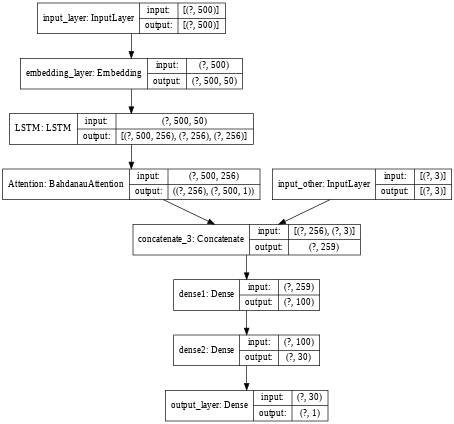

In [378]:
tf.keras.utils.plot_model(attn_model_f, show_shapes=True, dpi=48)

In [379]:
attn_model_f.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        min_delta=0,
                                                        patience=3,
                                                        verbose=0, mode='auto')

In [380]:
history = attn_model_f.fit([x_train, x2_train],
                    y_train,
                    epochs=5,
                    batch_size=200,
                    validation_split=.3, verbose=1, callbacks=[early_stopping_callback])

Epoch 1/5
112/112 [==============================] - 18s 159ms/step - loss: 0.5476 - accuracy: 0.7214 - val_loss: 0.5189 - val_accuracy: 0.7539
Epoch 2/5
112/112 [==============================] - 17s 156ms/step - loss: 0.5237 - accuracy: 0.7431 - val_loss: 0.5145 - val_accuracy: 0.7566
Epoch 3/5
112/112 [==============================] - 17s 155ms/step - loss: 0.5127 - accuracy: 0.7511 - val_loss: 0.5079 - val_accuracy: 0.7588
Epoch 4/5
112/112 [==============================] - 17s 155ms/step - loss: 0.4914 - accuracy: 0.7663 - val_loss: 0.5051 - val_accuracy: 0.7634
Epoch 5/5
112/112 [==============================] - 17s 155ms/step - loss: 0.4669 - accuracy: 0.7845 - val_loss: 0.5308 - val_accuracy: 0.7432


In [381]:
attn_model_f.evaluate([x_test, x2_test], y_test)

250/250 [==============================] - 3s 13ms/step - loss: 0.5313 - accuracy: 0.7372


[0.5312541723251343, 0.7372499704360962]

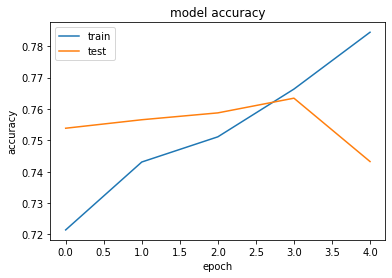

In [382]:
# summarize history for accuracy


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()